In [1]:
!git clone https://github.com/amnghd/Persian_poems_corpus.git

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 12.61 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (148/148), done.


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.3 MB/s eta 0:00:00


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
normalized_path ='/content/Persian_poems_corpus/normalized/'
my_poets = ['amir','attar', 'bahar', 'farrokhi', 'ferdousi', 'hafez','feyz',  'parvin', 'saadi',  'vahshi']
df = pd.DataFrame(columns = ['poems', 'label' ])
poems=[]
labels=[]
l=[]
for i in range(len(my_poets)):
  file1 = open(normalized_path + my_poets[i] + '_norm.txt', 'r')
  Lines = file1.readlines()
  c = 1
  for Line in Lines:
    Line = Line.strip('\n')
    Line = Line.strip('\t')
    if len(Line.split())>3:
      poems.append(Line)
      labels.append(i)
      l.append(len(Line.split()))

df['label'] = labels
df['poems'] = poems


In [5]:
from transformers import AutoConfig, AutoTokenizer, TFAutoModel

config = AutoConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
model = TFAutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

#text = "ما در هوشواره معتقدیم با انتقال صحیح دانش و آگاهی، همه افراد میتوانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است."
#tokenizer.tokenize(text)


Some layers from the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [6]:
# Split the data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=42)

In [7]:
from keras.utils import to_categorical
# Get the unique labels
labels = train_df["label"].unique()
num_labels = len(labels)



In [8]:
import numpy

all_labels = numpy.concatenate([train_df["label"], val_df["label"], test_df["label"]])
le = LabelEncoder()
le.fit(all_labels)
num_labels = len(le.classes_)
train_labels = to_categorical(le.transform(train_df["label"]), num_labels)
val_labels = to_categorical(le.transform(val_df["label"]), num_labels)
test_labels = to_categorical(le.transform(test_df["label"]), num_labels)


In [9]:
import tensorflow as tf


# Convert the poems text into BERT-readable input format
def convert_text_to_bert_input(text, tokenizer):
    input_ids = []
    attention_masks = []

    for poem in text:
        encoded_dict = tokenizer.encode_plus(
                            poem,
                            add_special_tokens=True,
                            max_length=32,
                            pad_to_max_length=True,
                            return_attention_mask=True,
                            return_tensors='tf'
                        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    return input_ids, attention_masks

In [10]:

train_text = train_df["poems"].tolist()
val_text = val_df["poems"].tolist()
test_text = test_df["poems"].tolist()

In [11]:

train_inputs, train_masks = convert_text_to_bert_input(train_text, tokenizer)
val_inputs, val_masks = convert_text_to_bert_input(val_text, tokenizer)
test_inputs, test_masks = convert_text_to_bert_input(test_text, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

**part A**

In [ ]:
classifier_pretrain_model.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=3, batch_size=16)

Epoch 1/3
14775/14775 [==============================] - 1084s 73ms/step - loss: 1.6893 - accuracy: 0.4566 - val_loss: 1.6035 - val_accuracy: 0.4964
Epoch 2/3
14775/14775 [==============================] - 1061s 72ms/step - loss: 1.6482 - accuracy: 0.4680 - val_loss: 1.5446 - val_accuracy: 0.5048
Epoch 3/3
14775/14775 [==============================] - 1059s 72ms/step - loss: 1.6398 - accuracy: 0.4712 - val_loss: 1.5126 - val_accuracy: 0.5111


In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from keras.layers import Input, Dense
from keras.models import Model

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

# Load the BERT model
model = TFAutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

model.bert.trainable = False

inputs = Input(shape=(None,), dtype='int32', name='input_word_ids')

pooled_output = model(inputs)[1]

output = Dense(units=num_labels, activation='softmax')(pooled_output)

classifier_pretrain_model = Model(inputs=inputs, outputs=output)
classifier_pretrain_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Some layers from the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:



classifier_pretrain_model.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=3, batch_size=16)


Some layers from the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
14775/14775 [==============================] - 1046s 70ms/step - loss: 1.6879 - accuracy: 0.4569 - val_loss: 1.5440 - val_accuracy: 0.5044
Epoch 2/3
14775/14775 [==============================] - 1015s 69ms/step - loss: 1.6466 - accuracy: 0.4677 - val_loss: 1.5377 - val_accuracy: 0.5061
Epoch 3/3
14775/14775 [==============================] - 1014s 69ms/step - loss: 1.6376 - accuracy: 0.4705 - val_loss: 1.5304 - val_accuracy: 0.5091


4523/4523 [==============================] - 355s 78ms/step


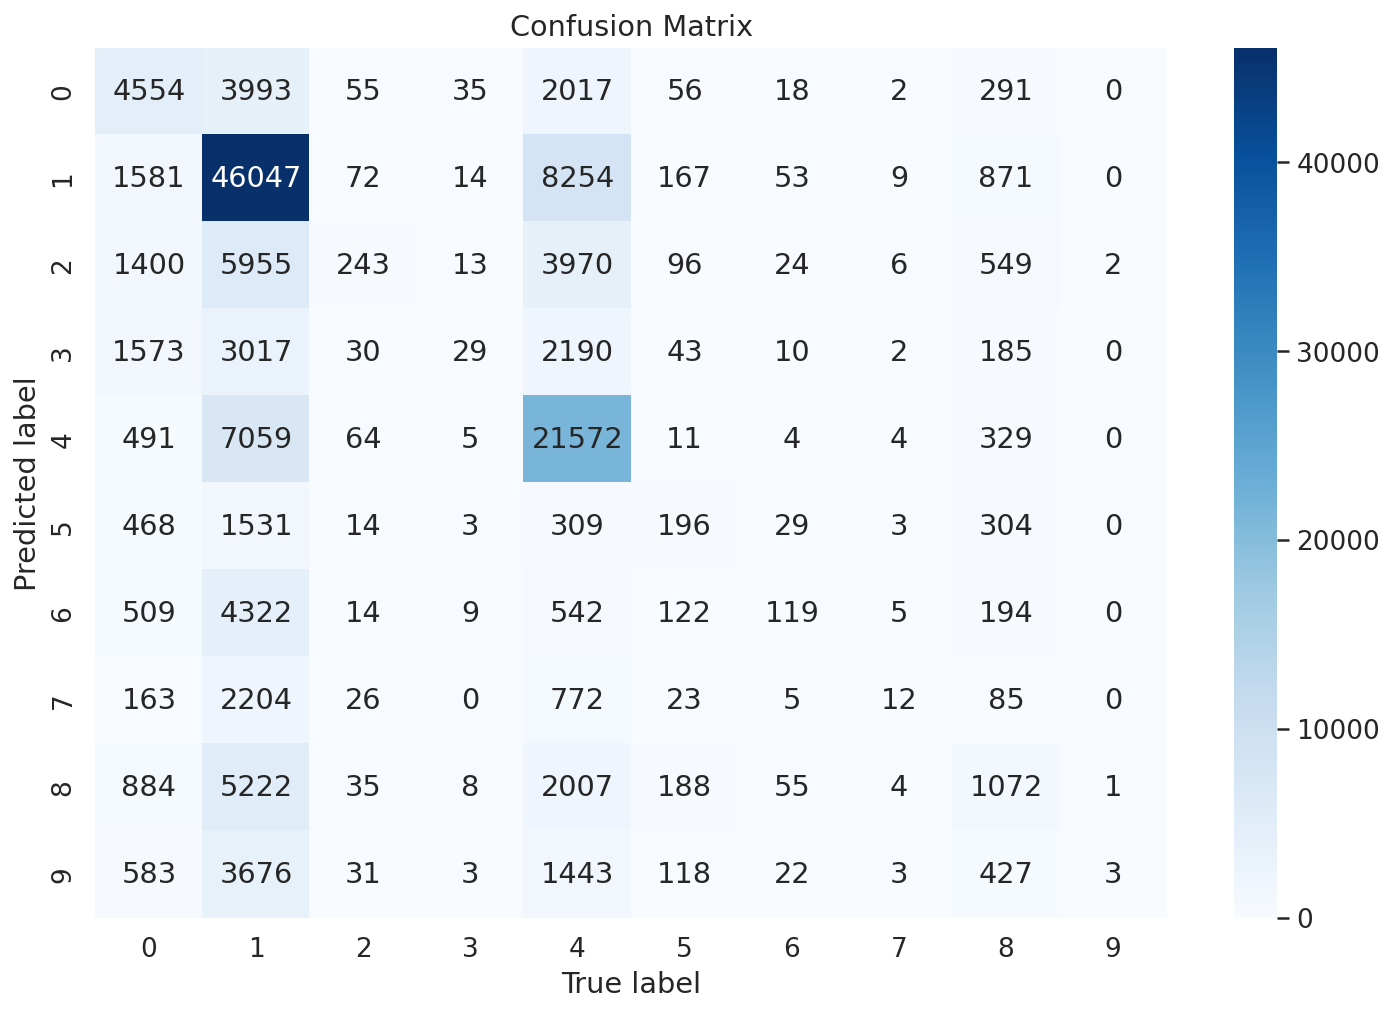

Accuracy: 0.5102
Loss: 1.5283
Micro F1 Score: 0.5102


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Evaluate the model on the test data
results = classifier_pretrain_model.evaluate(test_inputs, test_labels)

# Extract the accuracy and loss
accuracy = results[1]
loss = results[0]

# Get the predicted class labels
predicted_labels = np.argmax(classifier_pretrain_model.predict(test_inputs), axis=1)

# Calculate the micro F1 score
microF1 = f1_score(test_labels.argmax(axis=1), predicted_labels, average='micro')

# Plot the confusion matrix
cm = confusion_matrix(test_labels.argmax(axis=1), predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy: {:.4f}".format(accuracy))
print("Loss: {:.4f}".format(loss))
print("Micro F1 Score: {:.4f}".format(microF1))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Evaluate the model on the test data
results = classifier_pretrain_model.evaluate(test_inputs, test_labels)

# Extract the accuracy and loss
accuracy = results[1]
loss = results[0]

# Get the predicted class labels
predicted_labels = np.argmax(classifier_pretrain_model.predict(test_inputs), axis=1)

# Calculate the micro F1 score
microF1 = f1_score(test_labels.argmax(axis=1), predicted_labels, average='micro')

# Plot the confusion matrix
cm = confusion_matrix(test_labels.argmax(axis=1), predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy: {:.4f}".format(accuracy))
print("Loss: {:.4f}".format(loss))
print("Micro F1 Score: {:.4f}".format(microF1))

**part b**

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from keras.layers import Input, Dense
from keras.models import Model



tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

model = TFAutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

model.bert.trainable = True


inputs = Input(shape=(None,), dtype='int32', name='input_word_ids')


pooled_output = model(inputs)[1]

output = Dense(units=num_labels, activation='softmax')(pooled_output)

classifier_trainable_model = Model(inputs=inputs, outputs=output)

classifier_trainable_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


Some layers from the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:

classifier_trainable_model.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=3, batch_size=1, callbacks=[early_stopping])


Some layers from the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
236397/236397 [==============================] - 7214s 30ms/step - loss: 1.8645 - accuracy: 0.3928 - val_loss: 1.8552 - val_accuracy: 0.3937
Epoch 2/3
236397/236397 [==============================] - 7147s 30ms/step - loss: 1.8575 - accuracy: 0.3939 - val_loss: 1.8534 - val_accuracy: 0.3937
Epoch 3/3
236397/236397 [==============================] - 6723s 28ms/step - loss: 1.8573 - accuracy: 0.3938 - val_loss: 1.8555 - val_accuracy: 0.3937


4523/4523 [==============================] - 358s 79ms/step


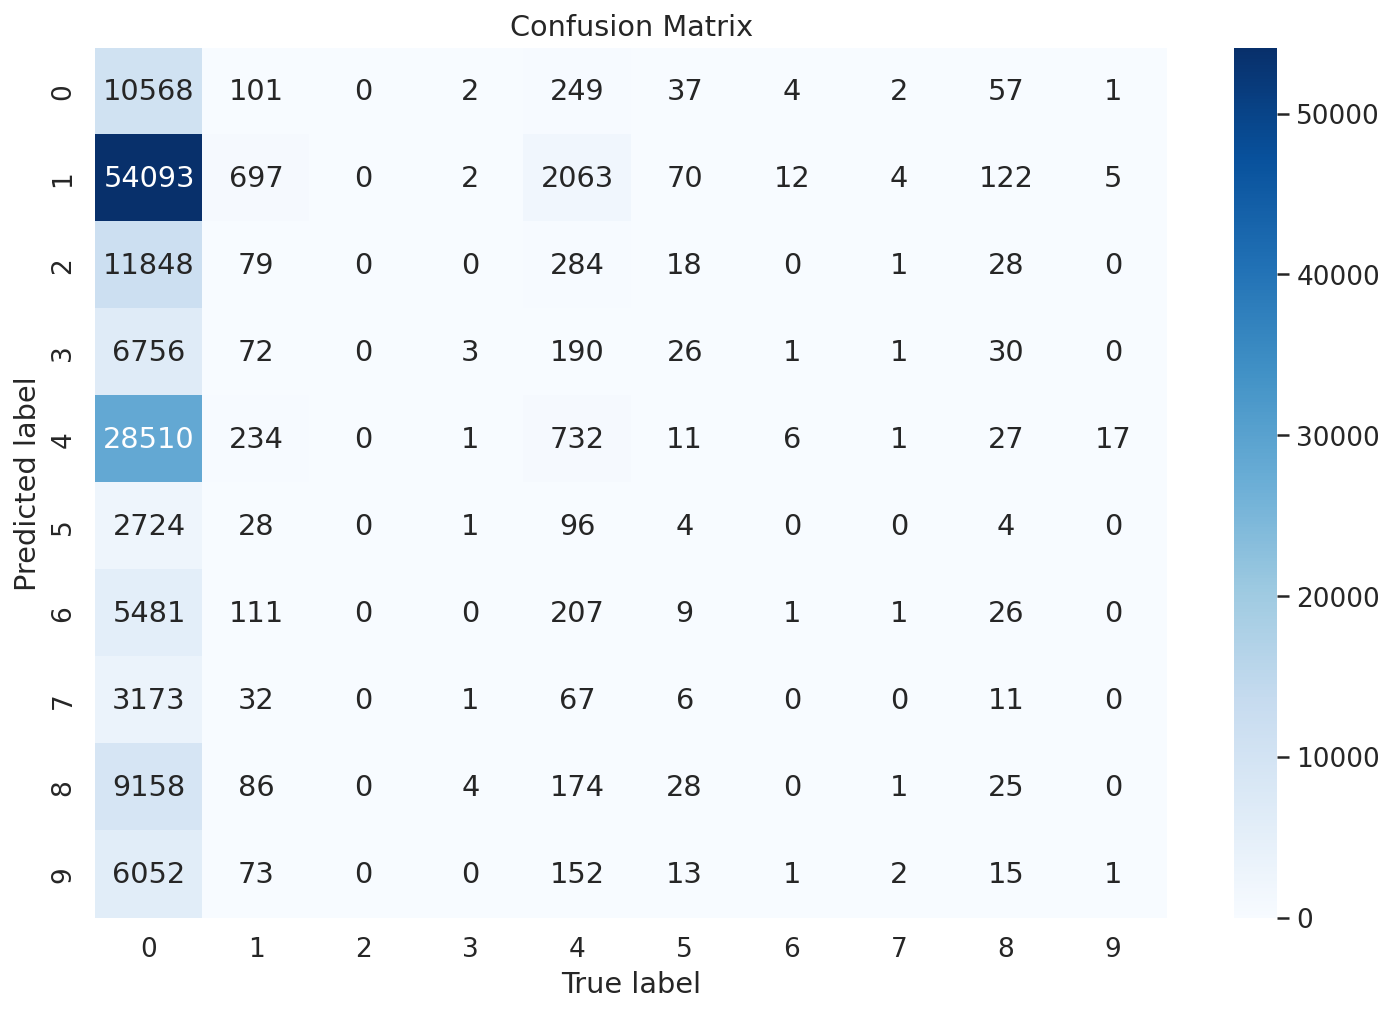

Accuracy: 0.0831
Loss: 2.3069
Micro F1 Score: 0.0831


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Evaluate the model on the test data
results = classifier_trainable_model.evaluate(test_inputs, test_labels)

# Extract the accuracy and loss
accuracy = results[1]
loss = results[0]

# Get the predicted class labels
predicted_labels = np.argmax(classifier_trainable_model.predict(test_inputs), axis=1)

# Calculate the micro F1 score
microF1 = f1_score(test_labels.argmax(axis=1), predicted_labels, average='micro')

# Plot the confusion matrix
cm = confusion_matrix(test_labels.argmax(axis=1), predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy: {:.4f}".format(accuracy))
print("Loss: {:.4f}".format(loss))
print("Micro F1 Score: {:.4f}".format(microF1))

In [14]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from keras.layers import Input, Dense
from keras.models import Model

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

# Load the BERT model
model = TFAutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

# Set the model to be trainable
model.bert.trainable = True

# Define the input layer
inputs = Input(shape=(None,), dtype='int32', name='input_word_ids')

# Pass the input layer through the BERT model to get the pooled output
pooled_output = model(inputs)[1]

# Define the output layer for the classification task
output = Dense(units=num_labels, activation='softmax')(pooled_output)

# Define the final classifier model
classifier_model = Model(inputs=inputs, outputs=output)

# Compile the model with an optimizer and a loss function
classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Train the model on the training data with early stopping
classifier_model.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=2, batch_size=1, callbacks=[early_stopping])

Some layers from the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
236397/236397 [==============================] - 17754s 75ms/step - loss: 2.3783 - accuracy: 0.2942 - val_loss: 2.3603 - val_accuracy: 0.2053
Epoch 2/2
 33377/236397 [===>..........................] - ETA: 4:01:12 - loss: 2.3759 - accuracy: 0.2963

KeyboardInterrupt: ignored

4523/4523 [==============================] - 359s 79ms/step


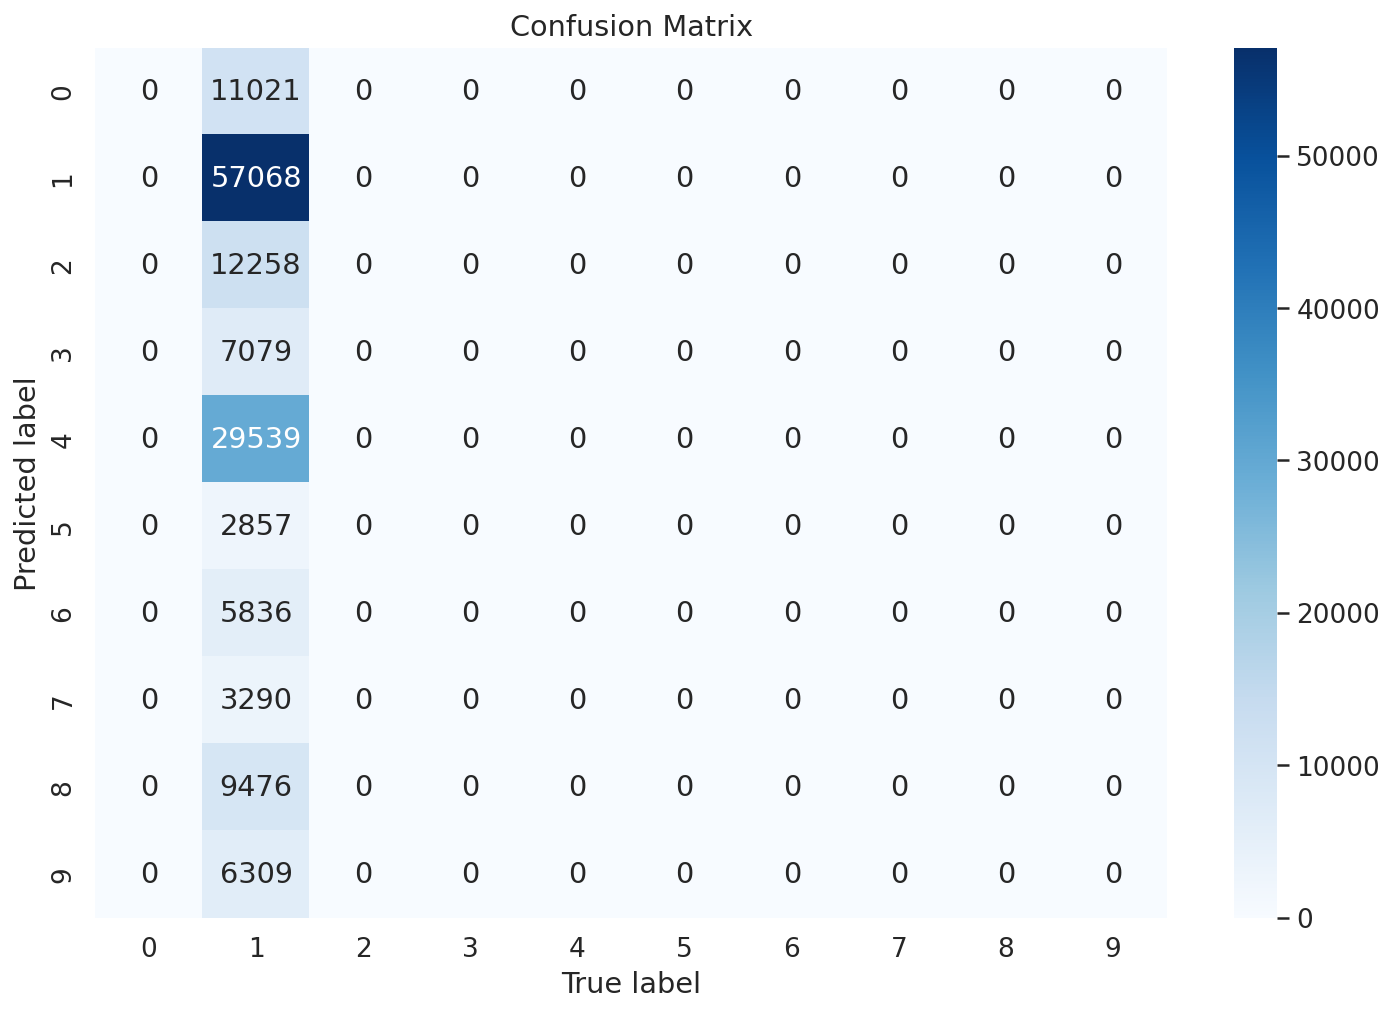

Accuracy: 0.3943
Loss: 2.0642
Micro F1 Score: 0.3943


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Evaluate the model on the test data
results = classifier_model.evaluate(test_inputs, test_labels)

# Extract the accuracy and loss
accuracy = results[1]
loss = results[0]

# Get the predicted class labels
predicted_labels = np.argmax(classifier_model.predict(test_inputs), axis=1)

# Calculate the micro F1 score
microF1 = f1_score(test_labels.argmax(axis=1), predicted_labels, average='micro')

# Plot the confusion matrix
cm = confusion_matrix(test_labels.argmax(axis=1), predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy: {:.4f}".format(accuracy))
print("Loss: {:.4f}".format(loss))
print("Micro F1 Score: {:.4f}".format(microF1))

چون محدودیت GPUداشتم نتوانستم که کامل ترین را انجام دهم به همین دلیل confusion matrix 

**part c**

In [ ]:
import random
total_verses = len(df)
sample_indices = random.sample(range(total_verses), 1000)
sample_verses = df.iloc[sample_indices]


In [ ]:
from sklearn.metrics import accuracy_score

predictions = classifier_pretrain_model.predict(test_inputs, batch_size=32)

predictions = [np.argmax(prediction) for prediction in predictions]

true_labels = [np.argmax(label) for label in test_labels]

accuracy = accuracy_score(true_labels, predictions)

print("Accuracy:", accuracy)


4523/4523 [==============================] - 369s 82ms/step
Accuracy: 0.5113415737945044


In [ ]:

perplexity = np.exp(-np.sum(np.log(predictions) * test_labels) / len(test_labels))

print("Perplexity:", perplexity)

<ipython-input-22-8c54d35534a5>:1: RuntimeWarning: divide by zero encountered in log
  perplexity = np.exp(-np.sum(np.log(predictions) * test_labels) / len(test_labels))


ValueError: ignored

In [ ]:
one_hot_labels = np.zeros((len(test_labels), 2))
for i, label in enumerate(test_labels):
    one_hot_labels[i, label] = 1

# Calculate perplexity
perplexity = np.exp(-np.sum(np.log(predictions) * one_hot_labels) / len(test_labels))
print("Perplexity:", perplexity)

In [ ]:

predictions = classifier_trainable_model.predict(test_inputs, batch_size=32)

predictions = [np.argmax(prediction) for prediction in predictions]

true_labels = [np.argmax(label) for label in test_labels]

accuracy = accuracy_score(true_labels, predictions)

print("Accuracy:", accuracy)


1456/4523 [========>.....................] - ETA: 4:20

KeyboardInterrupt: ignored

In [ ]:

probabilities = model.predict(test_inputs, batch_size=32)

perplexity = np.exp(-np.sum(np.log(probabilities) * test_labels) / len(test_labels))

print("Perplexity:", perplexity)


In [ ]:
from keras_nlp.metrics import Perplexity

In [ ]:
y_logits = model.predict({'input_ids':x['input_ids'],'attention_mask':x['attention_mask']},verbose=1)

In [ ]:
perplexity = Perplexity(mask_token_id=0,from_logits=True)
perplexity(df_test['label'].squeeze(),y_logits)